In [20]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    r1=1
    r2=2
    r3=-1
    r4=0
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u1_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)


#lambda
a=0
b=1
theta=0
delta=0
def init_cond_u1(x):
    q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    q2=(1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    return q1.real
    
def init_cond_u2(x):
    "2 tanh(x)"
    q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    q2=(1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    return q2.real

def init_cond_v1(x):
    q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    q2=(1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    return -q1.imag

def init_cond_v2(x):
    q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    q2=(1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-x[:,1:2])+1j*a*x[:,0:1]+1j*theta)/np.cosh(b*x[:,0:1]-2*a*b*x[:,1:2]+delta))
    return -q2.imag

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=8000,
    num_boundary=200,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

c:\tools\Anaconda3\python.exe
c:\tools\Anaconda3\python.exe


In [21]:
dde.config.set_default_float("float64")
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=10, display_every=10)

Set the default float type to float64
Compiling model...
Building feed-forward neural network...
'build' took 0.184490 s

'compile' took 4.454410 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.18e-03, 8.46e-05, 1.46e-04, 8.88e-05, 2.67e-01, 4.90e-03, 4.98e-02, 2.06e-04, 1.90e-02, 8.32e-04, 6.27e-03, 1.01e-03, 5.17e-02, 1.48e-01, 1.49e-01, 3.31e-02]    [1.18e-03, 8.46e-05, 1.46e-04, 8.88e-05, 2.67e-01, 4.90e-03, 4.98e-02, 2.06e-04, 1.90e-02, 8.32e-04, 6.27e-03, 1.01e-03, 5.17e-02, 1.48e-01, 1.49e-01, 3.31e-02]    []  
10        [6.53e-04, 4.60e-05, 9.02e-05, 4.87e-04, 1.21e-02, 7.25e-05, 9.84e-04, 2.48e-05, 1.30e-03, 6.72e-04, 8.

(<deepxde.model.LossHistory at 0x19341e9b340>,
 <deepxde.model.TrainState at 0x19341e9b490>)

In [22]:

dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=3000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...


TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float32, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64] that don't all match.

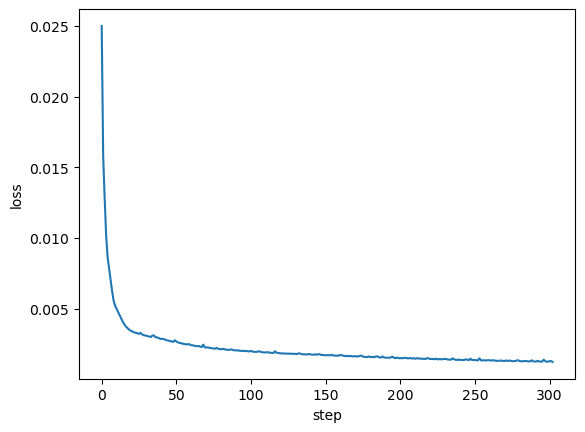

In [ ]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

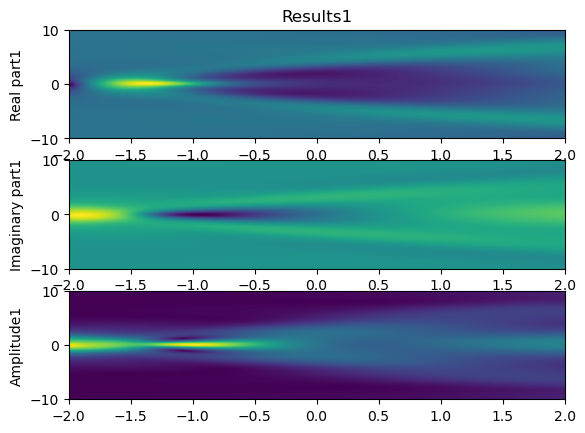

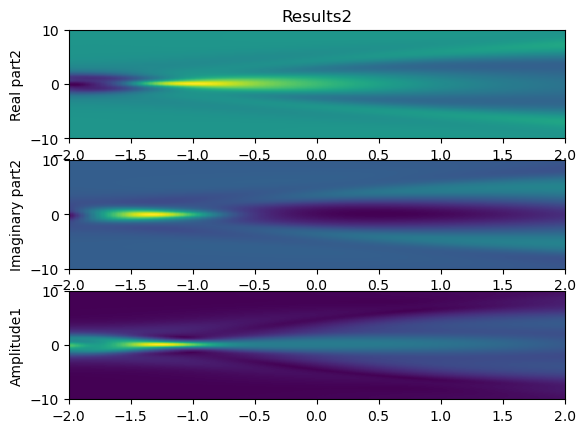

In [ ]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[    79077     86705     76205 ... 109166824 109056968 108680152]


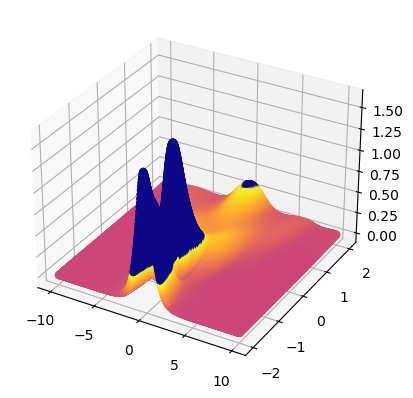

In [ ]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')


[   5682    5417    4790 ... 4240542 4193794 4094908]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


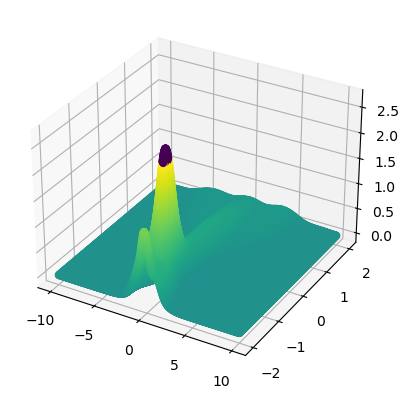

In [ ]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [ ]:
print(c)

1.1184673e-09
